# Activity recognition on the Capture24 dataset

## Neural networks for feature engineering

*This section assumes familiarity with [PyTorch](https://pytorch.org/)*

In this section, instead of using the hand-crafted features, we use a neural network on the raw accelerometer measurements so that we let the neural network automatically learn relevant features for classification.

###### Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
# from tqdm import tqdm
from tqdm.notebook import tqdm
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

# Function to plot dict of scores
def plot_scores(scores, xlabel=None, ylabel=None):
    fig, ax = plt.subplots()
    for key, vals in scores.items():
        ax.plot(vals, label=key)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    return fig, ax

 ###### Load dataset and hold out some instances for testing 

In [2]:
# data = np.load('capture24.npz', allow_pickle=True)
data = np.load('capture24_small.npz', allow_pickle=True)
print("Contents in capture24.npz:", data.files)
y, pid, time = data['y'], data['pid'], data['time']
# X_raw = utils.load_raw('X_raw.dat')
X_raw = np.load('X_raw_small.npy')
print("Raw data shape:", X_raw.shape)
print(np.unique(pid, return_counts=True))

# Hold out some participants for testing the model
pids_test = [2, 3]
mask_test = np.isin(pid, pids_test)
mask_train = ~mask_test
y_train, y_test = y[mask_train], y[mask_test]
pid_train, pid_test = pid[mask_train], pid[mask_test]
X_train = utils.ArrayFromMask(X_raw, mask_train)
X_test = utils.ArrayFromMask(X_raw, mask_test)
print("Shape of X_train", X_train.shape)
print("Shape of X_test", X_test.shape)

Contents in capture24.npz: ['X_feats', 'y', 'pid', 'time', 'annotation']
Raw data shape: (11016, 3, 3000)
(array([1, 2, 3, 4, 5]), array([ 977, 2277, 2714, 2051, 2997]))
Shape of X_train (6025, 3, 3000)
Shape of X_test (4991, 3, 3000)


 ###### Grab a GPU if there is one 

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cpu


###### Architecture design

As a baseline model, we use a convolutional neural network (CNN) with a typical pyramid-like structure. The input of the network is a `(N,3,3000)` array, corresponding to `N` instances of raw triaxial measurements of activity. The output of the network is a `(N,5)` array representing predicted *class scores* for each instance.
To obtain probabilities, we can pass each row to a softmax. Then to report a class label, we can pick the highest probability for each row. We output class scores instead of class probabilities or labels because the loss function that we will use operates on the scores (see further below).

In [4]:
class CNN(nn.Module):
    def __init__(self, output_dim, in_channels, num_filters_base=8):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels, num_filters_base,
                8, 4, 2, bias=False),  # state shape (N,num_filters_base,750)
            nn.BatchNorm1d(num_filters_base),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base, num_filters_base*2,
                6, 4, 2, bias=False),  # state shape (N,num_filters_base*2,188)
            nn.BatchNorm1d(num_filters_base*2),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*2, num_filters_base*4,
                8, 4, 2, bias=False),  # state shape (N,num_filters_base*4,47)
            nn.BatchNorm1d(num_filters_base*4),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*4, num_filters_base*8,
                3, 2, 1, bias=False),  # state shape (N,num_filters_base*8,24)
            nn.BatchNorm1d(num_filters_base*8),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*8, num_filters_base*16,
                4, 2, 1, bias=False),  # state shape (N,num_filters_base*16,12)
            nn.BatchNorm1d(num_filters_base*16),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*16, num_filters_base*32,
                4, 2, 1, bias=False),  # state shape (N,num_filters_base*32,6)
            nn.BatchNorm1d(num_filters_base*32),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*32, num_filters_base*64,
                6, 1, 0, bias=False),  # state shape (N,num_filters_base*64,1)
            nn.BatchNorm1d(num_filters_base*64),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*64, output_dim,
                1, 1, 0, bias=True)  # state shape (N,output_dim,1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.cnn(x).view(x.shape[0],-1)

###### Helper functions

We need a few helper functions:
- A data loader that will provide the mini-batches during training.
- A helper function that forward-passes the model on a dataset by batches &mdash; this is simply to prevent the memory from blowing up.
- A function to train a Hidden Markov Model (HMM) using the probabilistic predictions of the model for smoothing.
- A function that evaluates the model+HMM on a dataset, to be used to track the performance during training.

Finally, a standard procedure is to normalize the input data via zero-centering and scaling to unit variance &mdash; this has shown to aid the optimization of neural networks. For the latter, we use our utility function `mu_std()` to obtain the mean and standard deviation, then use these to normalize in the data loader. Note: if `X_train` fits in memory, simply `np.mean(X_train, axis=0)` and `np.std(X_train, axis=0)`.

In [5]:
print("Computing normalization parameters...")
mu, std = utils.mu_std(X_train)

def create_dataloader(X, y=None, batch_size=1, mu=None, std=None, shuffle=False):
    ''' Create a (batch) iterator over the dataset. Alternatively, use PyTorch
    Dataset and DataLoader classes -- See
    https://pytorch.org/tutorials/beginner/data_loading_tutorial.html '''
    if shuffle:
        idxs = np.random.permutation(np.arange(len(X)))
    else:
        idxs = np.arange(len(X))
    for i in range(0, len(idxs), batch_size):
        idxs_batch = idxs[i:i+batch_size]
        X_batch = torch.from_numpy(X[idxs_batch])
        if mu is not None and std is not None:
            X_batch = (X_batch - mu) / (std + 1e-16)  # normalization
        if y is None:
            yield X_batch
        else:
            y_batch = torch.from_numpy(y[idxs_batch])
            yield X_batch, y_batch

def forward_by_batches(cnn, X):
    ''' Forward pass CNN model on a dataset. Do this by batches so that we do
    not blow up the memory. '''
    Y = []
    cnn.eval()
    with torch.no_grad():
        for x in create_dataloader(X, batch_size=512, shuffle=False):  # do not shuffle here!
            x = x.to(device)
            Y.append(cnn(x))
    cnn.train()
    Y = torch.cat(Y)
    return Y

def train_hmm(cnn, X, y):
    ''' Use the probabilistic predictions of the CNN to compute the Hidden
    Markov Model parameters '''
    Y_pred = forward_by_batches(cnn, X)  # scores
    Y_pred = F.softmax(Y_pred, dim=1)  # probabilities
    Y_pred = Y_pred.cpu().numpy()  # cast to numpy array
    prior, emission, transition = utils.train_hmm(Y_pred, y)
    return prior, emission, transition

def evaluate_model(cnn, prior, emission, transition, X, y, pid=None):
    Y_pred = forward_by_batches(cnn, X)  # scores
    Y_pred = F.softmax(Y_pred, dim=1)  # probabilities
    y_pred = torch.argmax(Y_pred, dim=1)  # classes
    y_pred = y_pred.cpu().numpy()  # cast to numpy array
    y_pred = utils.viterbi(y_pred, prior, emission, transition)  # HMM smoothing
    kappa = utils.cohen_kappa_score(y, y_pred, pid)
    accuracy = utils.accuracy_score(y, y_pred, pid)
    return kappa, accuracy

Computing normalization parameters...


###### Hyperparameters, model instantiation, loss function and optimizer

Now we set the hyperparameters, instantiate the model, define the loss
function (we use cross entropy for multiclass classification) and optimizer
(we use AMSGRAD &mdash; a variant of SGD).

In [6]:
num_filters_base = 8  # "size" of the neural network -- see CNN class definition
in_channels = 3  # num of input channels -- equal to 3 for our raw triaxial timeseries
output_dim = utils.NUM_CLASSES  # number of classes (sleep, sedentary, etc...)
num_epochs = 10  # num of epochs (full loops though the training set) for SGD training
lr = 1e-3  # learning rate in SGD
batch_size = 32  # size of the mini-batch in SGD

cnn = CNN(
    in_channels=in_channels,
    output_dim=output_dim,
    num_filters_base=num_filters_base
).to(device)
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr, amsgrad=True)

CNN(
  (cnn): Sequential(
    (0): Conv1d(3, 8, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(8, 16, kernel_size=(6,), stride=(4,), padding=(2,), bias=False)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(16, 32, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): 

###### Training

Training via mini-batch gradient descent begins here. We loop through the training set `num_epochs` times with the `dataloader` iterator.

In [7]:
loss_history = []
kappa_history = {'train':[], 'test':[]}
accuracy_history = {'train':[], 'test':[]}
for i in tqdm(range(num_epochs)):
    dataloader = create_dataloader(X_train, y_train, batch_size, shuffle=True)
    for x, target in dataloader:
        x, target = x.to(device), target.to(device)
        cnn.zero_grad()
        output = cnn(x)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        # Logging -- cross entropy loss
        loss_history.append(loss.item())

    # -------------------------------------------------------------------------
    # Evalutate performance at the end of each epoch (full loop through the
    # training set). We could also do this at every iteration, but this would
    # be very expensive since we are evaluating on the entire dataset.
    # Aditionally, at the end of the epoch we train a Hidden Markov Model to
    # smooth the predictions of the CNN.
    # -------------------------------------------------------------------------

    prior, emission, transition = train_hmm(cnn, X_train, y_train)

    # Logging -- performance on train set
    kappa, accuracy = evaluate_model(
        cnn, prior, emission, transition, X_train, y_train, pid_train)
    kappa_history['train'].append(kappa)
    accuracy_history['train'].append(accuracy)
    # Logging -- performance on test set
    kappa, accuracy = evaluate_model(
        cnn, prior, emission, transition, X_test, y_test, pid_test)
    kappa_history['test'].append(kappa)
    accuracy_history['test'].append(accuracy)

 ###### Plot score and loss history 

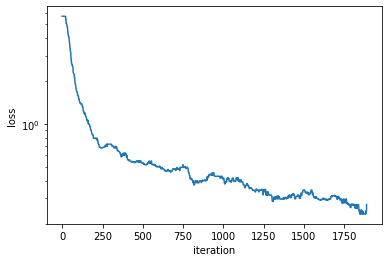

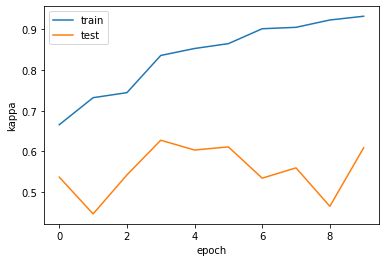

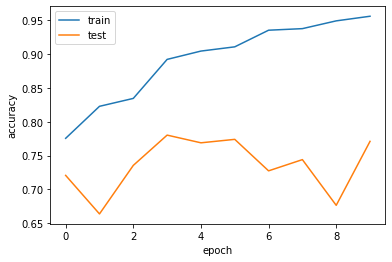

In [8]:
# Loss history
fig, ax = plt.subplots()
ax.semilogy(median_filter(loss_history, size=100))  # smooth for visualization
ax.set_ylabel('loss')
ax.set_xlabel('iteration')
fig.show()
# fig.savefig('cnn_loss.png')

# Score history
fig, _ = plot_scores(kappa_history, xlabel='epoch', ylabel='kappa')
fig.show()
# fig.savefig('cnn_cohen_scores.png')
fig, _ = plot_scores(accuracy_history, xlabel='epoch', ylabel='accuracy')
fig.show()
# fig.savefig('cnn_accuracy_scores.png')

###### Ideas
- Implement an early stopping mechanism to select the model at its best out-of-sample performance. Do we track kappa or accuracy?
- Add a 4th channel containing the vector magnitude, i.e. $(x,y,z,m)$ where $m = \sqrt{x^2+y^2+z^2}$
- Instead of Cartesian coordinates, try [Spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system).
- Modify the architecture. Feel free to use recent architectures such as ResNet.

###### References

- [A recipe for training neural networks](http://karpathy.github.io/2019/04/25/recipe/)